In [1]:
# Import all related libraries

import os

%matplotlib inline
import sys

from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    plot_confusion_matrix,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC

In [2]:
# Load Dataset
uploaded = files.upload()
df = pd.read_csv("UCI_Credit_Card.csv", encoding="utf-8")
df["default.payment.next.month"].value_counts()

Saving UCI_Credit_Card.csv to UCI_Credit_Card.csv


0    23364
1     6636
Name: default.payment.next.month, dtype: int64

In [3]:
df["default.payment.next.month"].value_counts(normalize=True)

0    0.7788
1    0.2212
Name: default.payment.next.month, dtype: float64

From the result above, we note that there is class imbalance.

In [4]:
# Check the feature information

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

Preprocessing Steps:
1. LIMIT_BAL, all of the BILL_AMT and PAY_AMT, and AGE columns are numeric features, apply StandardScaler. 
2. Repayment status(eg. PAY_0) is ordinal feature, but we don't need to apply OrdinalEncoder since it is already preprocessed. 
3. Sex is binary features and Education, Marriage is a categorical feature, apply OneHotEnconder. 
4. Drop ID column
5. Drop default.payment.next.month (label)

In [6]:
 # 80%-20% train test split on X and y

train_df, test_df = train_test_split(df, test_size=0.2) 

In [7]:
train_df.shape

(24000, 25)

# EDA

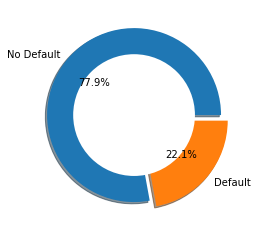

In [8]:
myexplode = [0, 0.1]
plt.pie(df['default.payment.next.month'].value_counts(), labels = ['No Default', 'Default'], 
        explode = myexplode, autopct='%1.1f%%', shadow = True, colors = ['tab:blue', 'tab:orange'])
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.show()

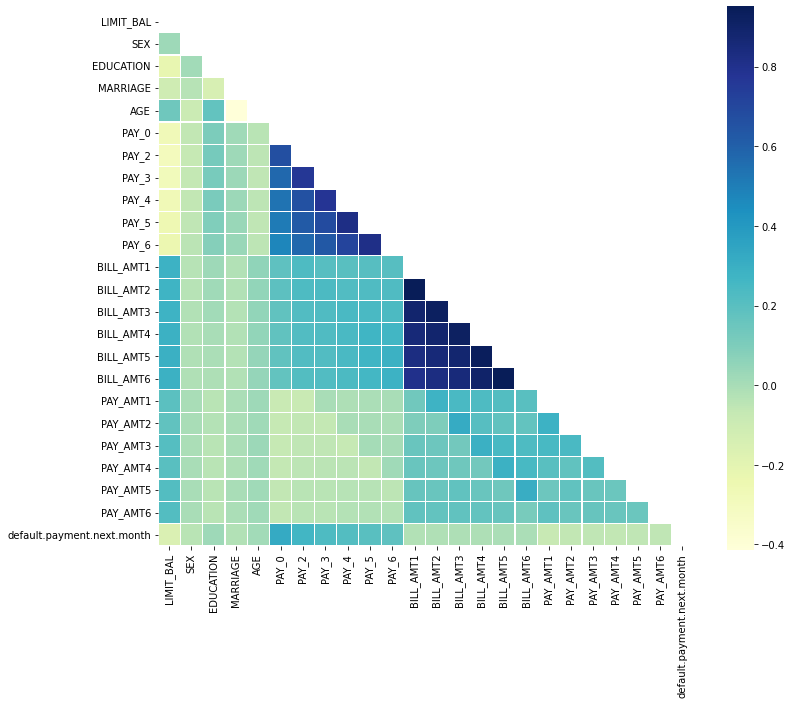

In [9]:
mask = np.triu(np.ones_like(df.iloc[:,1:].corr()))
plt.figure(figsize = (12,10))
sns.heatmap(df.iloc[:,1:].corr(), mask = mask, cmap = 'YlGnBu', square = True, linewidths = .2)

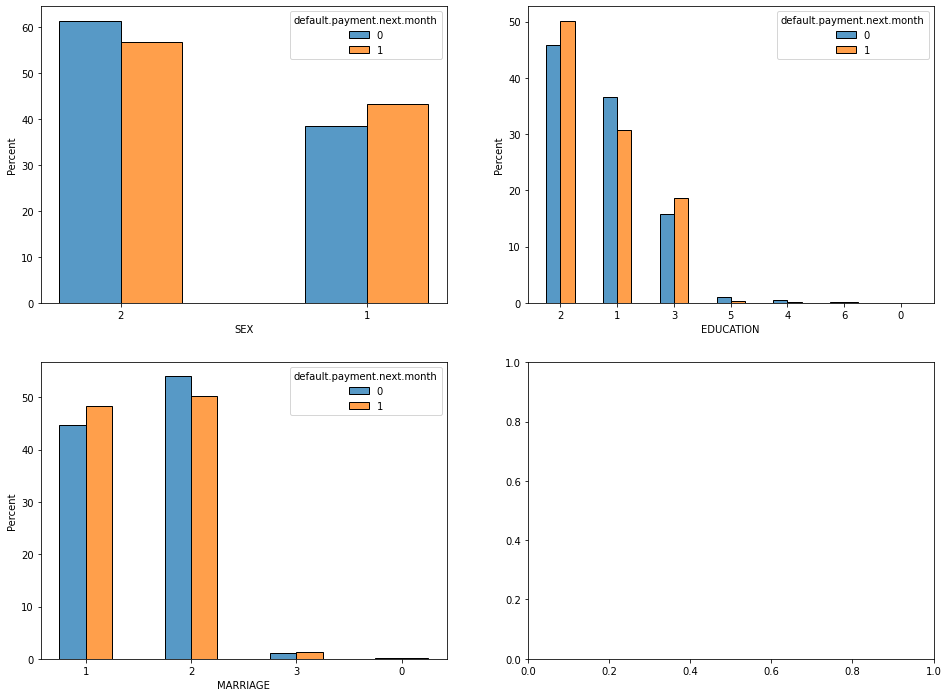

In [10]:
categories = ['SEX', 'EDUCATION', 'MARRIAGE']
fig, axes = plt.subplots(2, 2, figsize = (16, 12))

for i in range(len(categories)):
    ax = axes[int(i/2), i%2]
    var = categories[i]
    sns.histplot(x = df[var].apply(str), hue=df['default.payment.next.month'], ax = ax, 
                  stat = 'percent', multiple = 'dodge', shrink = 0.5, common_norm=False,)

In [ ]:
# split the labels

no = train_df[train_df["default.payment.next.month"] == 0]
yes = train_df[train_df["default.payment.next.month"] == 1]

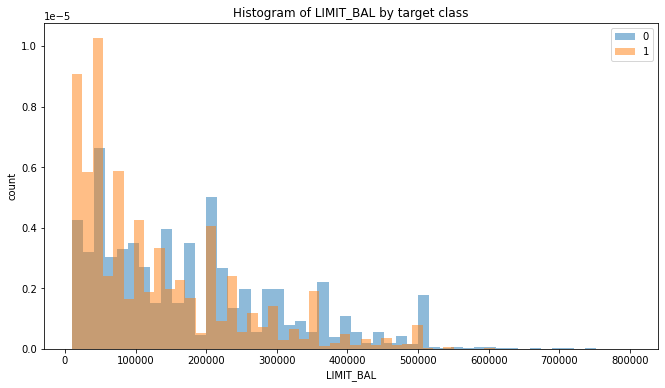

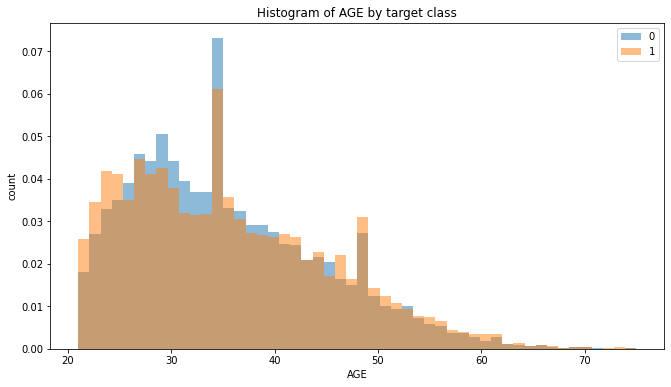

In [ ]:
# plot the back-to-back histogram of 2 groups for 2 different columns

cols = ['LIMIT_BAL', 'AGE']
#range(2) [0,1]
for col in range(len(cols)):
    plt.figure(figsize=(11,6))
    plt.hist(x=cols[col], data=no, label='0', bins=50, alpha=0.5,density=True)
    plt.hist(x=cols[col], data=yes, label='1', bins=50, alpha=0.5,density=True)
    plt.title('Histogram of {} by target class'.format(cols[col]))
    plt.xlabel(cols[col])
    plt.ylabel('count')
    plt.legend()
    plt.show()

1. From the plots above, it is very clear that there is an imbalance issue in the target column.
2. In addition, the LIMIT_BAL plot shows that people who will default the payment are within the 0-0.5 credit range, and within the 0.5-0.6 range, it only contains people who will not default.
3. The Age plot shows that the distribution of "yes" and "no" for default payment is similar. However, within the 25- 30 yrs age range, more people tend to not default payment.

# Preprocessing

In [ ]:
# drop the label

target = "default.payment.next.month"
X_train, y_train = train_df.drop(columns=[target]), train_df[target]
X_test, y_test = test_df.drop(columns=[target]), test_df[target]
train_df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
24279,24280,70000.0,1,2,2,30,0,0,0,0,...,69161.0,68264.0,61757.0,2347.0,3182.0,3144.0,2600.0,2360.0,1300.0,0
20768,20769,50000.0,1,3,1,40,2,0,0,0,...,40748.0,41273.0,42206.0,1700.0,1700.0,2000.0,1500.0,1600.0,1600.0,0
26234,26235,50000.0,2,3,1,35,2,2,4,3,...,50794.0,49376.0,50185.0,6000.0,0.0,1.0,1.0,1915.0,2000.0,1
5092,5093,520000.0,1,2,2,32,0,0,0,0,...,6426.0,4045.0,1806.0,1222.0,1200.0,505.0,502.0,100.0,216338.0,0
9691,9692,130000.0,2,1,2,29,-1,3,2,2,...,78.0,78.0,-121.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [ ]:
# create pipeline to preprocess data

numeric_features = ["LIMIT_BAL", "AGE", "BILL_AMT1", "BILL_AMT2", "BILL_AMT3", 
                    "BILL_AMT4", "BILL_AMT5", "BILL_AMT6", "PAY_AMT1", "PAY_AMT2",
                    "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"]
drop_features = ["ID"]

binary_features = ['SEX']
categorical_features = ['EDUCATION', 'MARRIAGE']
preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(drop='if_binary'), binary_features),
    (OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ("drop", drop_features)
)
preprocessor

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2',
                                  'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5',
                                  'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
                                  'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
                                  'PAY_AMT6']),
                                ('onehotencoder-1',
                                 OneHotEncoder(drop='if_binary'), ['SEX']),
                                ('onehotencoder-2',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['EDUCATION', 'MARRIAGE']),
                                ('drop', 'drop', ['ID'])])

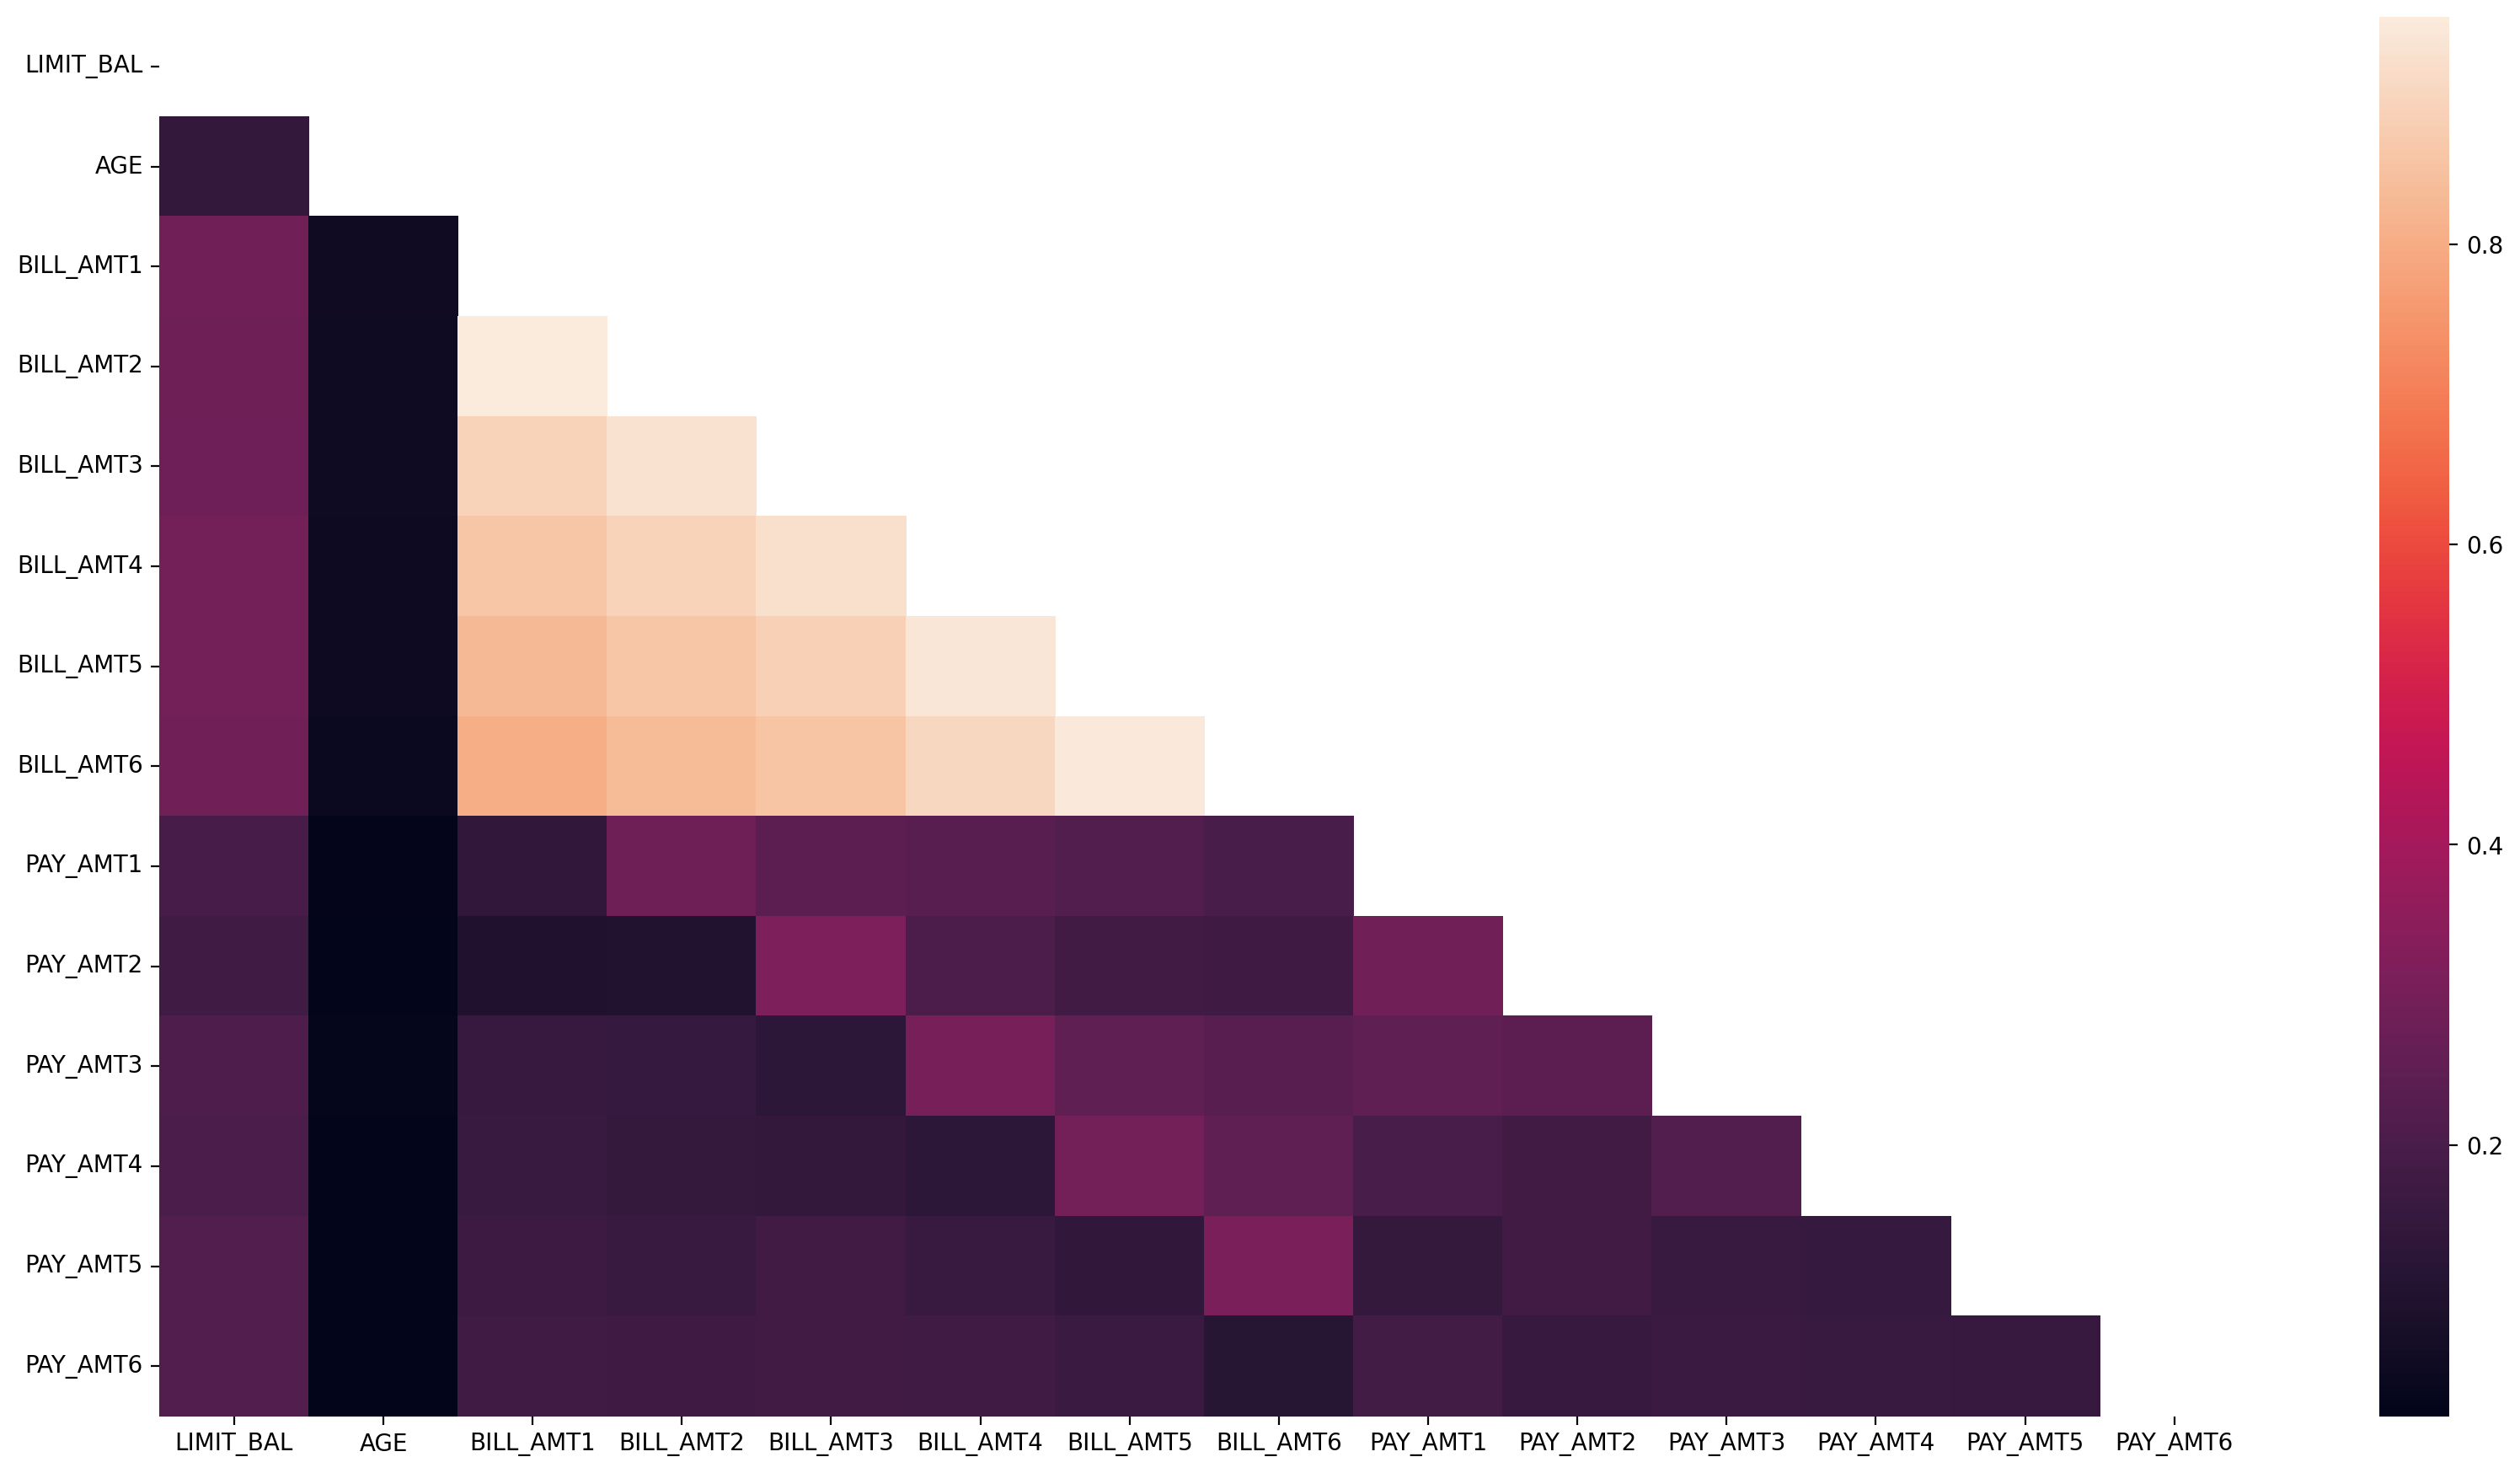

In [ ]:
import seaborn
corr = df[numeric_features].corr()
mask = np.zeros_like(corr, dtype=np.bool)  
mask[np.triu_indices_from(mask)]= True
plt.figure(figsize=(20,11),dpi=200)
seaborn.heatmap(corr, mask=mask)

In [ ]:
mask

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True],
       [False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True],
       [False, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True],
       [False, False, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True],
       [False, False, False, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True],
       [False, False, False, False, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True],
       [False, False, False, False, False, False,  True,  True,  True,
         True,  True,  True,  True,  True],
       [False, False, False, False, False, False, False,  True,  True,
         True,  True,  True,  True,  True],
       [False, False, False, False, False, False, False, False,  True,
         

# Model Building

In [ ]:
scoring_metric = 'f1'
results = dict()

In [ ]:
import warnings

warnings.simplefilter(action="ignore", category=DeprecationWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [ ]:
# Baseline Model

dummy = DummyClassifier()
pd.DataFrame(cross_validate(dummy, X_train, y_train, return_train_score=True, scoring=scoring_metric,cv=10)).mean()

fit_time       0.010047
score_time     0.004166
test_score     0.000000
train_score    0.000000
dtype: float64

In [ ]:
# Logistic Regression

logistic_pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=1000, class_weight='balanced'))
pd.DataFrame(cross_validate(logistic_pipe, X_train, y_train, return_train_score=True, scoring=scoring_metric)).mean()

fit_time       0.988040
score_time     0.019300
test_score     0.416823
train_score    0.418152
dtype: float64

In [ ]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [ ]:
# address for class imbalance

ratio_lgbm = list(y_train==0).count(True)/list(y_train==1).count(True)
ratio_cat0 = list(y_train==0).count(True)/len(y_train)
ratio_cat1 = 1-ratio_cat0

In [ ]:
!pip3 install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from catboost import CatBoostClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

pipe_dt = DecisionTreeClassifier(class_weight='balanced')
pipe_rf = RandomForestClassifier(class_weight='balanced')
pipe_xgb = XGBClassifier(eval_metric="logloss", verbosity=0, scale_pos_weight=ratio_lgbm)
pipe_lgbm = LGBMClassifier(scale_pos_weight=ratio_lgbm)
pipe_catboost = CatBoostClassifier(verbose=0, class_weights=[ratio_cat0, ratio_cat1])
classifiers = {
    "decision tree": pipe_dt,
    "random forest": pipe_rf,
    "XGBoost": pipe_xgb,
    "LightGBM": pipe_lgbm,
    "CatBoost": pipe_catboost,
}

for (name, model) in classifiers.items():
    pipe = make_pipeline(preprocessor, model)
    results[name] = mean_std_cross_val_scores(
        pipe, X_train, y_train, return_train_score=True, scoring=scoring_metric
    )

pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
decision tree,0.484 (+/- 0.027),0.015 (+/- 0.003),0.330 (+/- 0.005),0.998 (+/- 0.000)
random forest,6.282 (+/- 0.588),0.150 (+/- 0.005),0.249 (+/- 0.010),0.998 (+/- 0.000)
XGBoost,2.253 (+/- 0.020),0.029 (+/- 0.001),0.474 (+/- 0.007),0.504 (+/- 0.003)
LightGBM,0.633 (+/- 0.004),0.043 (+/- 0.001),0.472 (+/- 0.003),0.617 (+/- 0.001)
CatBoost,13.003 (+/- 2.252),0.090 (+/- 0.064),0.061 (+/- 0.010),0.118 (+/- 0.005)


# Hyperparamter Tuning

In [ ]:
# XGBoost

from scipy.stats import randint

param_grid_xgb = {
    "xgbclassifier__n_estimators": randint(10, 100),
    "xgbclassifier__learning_rate": [0.01, 0.1]
}

pipe_xgb = make_pipeline(
    preprocessor,
    classifiers["XGBoost"],
)

random_search_xgb = RandomizedSearchCV(
    pipe_xgb,
    param_grid_xgb,
    n_iter=50,
    scoring=scoring_metric,
    return_train_score=True,
)

random_search_xgb.fit(X_train, y_train);

pd.DataFrame(random_search_xgb.cv_results_)[
    [
        "mean_test_score",
        "param_xgbclassifier__n_estimators",
        "param_xgbclassifier__learning_rate",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T


rank_test_score,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,45,45,48,49,50
mean_test_score,0.473494,0.47321,0.473159,0.473117,0.472764,0.472392,0.47235,0.472114,0.471746,0.471301,...,0.417962,0.416571,0.415664,0.414078,0.413778,0.413778,0.413778,0.412546,0.412145,0.411285
param_xgbclassifier__n_estimators,85,80,87,78,92,73,64,74,71,72,...,35,32,30,27,23,23,23,15,22,19
param_xgbclassifier__learning_rate,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
mean_fit_time,1.973674,1.803893,2.397495,1.759531,2.137525,1.756344,1.467566,1.731751,1.625571,1.632351,...,0.872198,0.791523,0.765863,0.678354,0.767696,0.578909,0.57576,0.412293,0.787862,0.546591


In [ ]:
best_pipe_xgb = random_search_xgb.best_estimator_
results['xgb_best'] = mean_std_cross_val_scores(best_pipe_xgb, X_train, y_train, return_train_score=True, scoring=scoring_metric)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
decision tree,0.484 (+/- 0.027),0.015 (+/- 0.003),0.330 (+/- 0.005),0.998 (+/- 0.000)
random forest,6.282 (+/- 0.588),0.150 (+/- 0.005),0.249 (+/- 0.010),0.998 (+/- 0.000)
XGBoost,2.253 (+/- 0.020),0.029 (+/- 0.001),0.474 (+/- 0.007),0.504 (+/- 0.003)
LightGBM,0.633 (+/- 0.004),0.043 (+/- 0.001),0.472 (+/- 0.003),0.617 (+/- 0.001)
CatBoost,13.003 (+/- 2.252),0.090 (+/- 0.064),0.061 (+/- 0.010),0.118 (+/- 0.005)
xgb_best,2.110 (+/- 0.176),0.029 (+/- 0.001),0.473 (+/- 0.006),0.500 (+/- 0.003)


In [ ]:
# LGBM

pipe_lgbm = make_pipeline(
    preprocessor,
    classifiers["LightGBM"],
)

param_grid_lgbm = {
    'lgbmclassifier__num_leaves': randint(6,50),
    'lgbmclassifier__min_child_samples': randint(100,500),
    'lgbmclassifier__min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4]
}

random_search_lgbm = RandomizedSearchCV(
    pipe_lgbm,
    param_grid_lgbm,
    n_iter=50,
    scoring=scoring_metric,
    return_train_score=True,
)

random_search_lgbm.fit(X_train, y_train)

pd.DataFrame(random_search_lgbm.cv_results_)[
    [
        "mean_test_score",
        "param_lgbmclassifier__num_leaves",
        "param_lgbmclassifier__min_child_samples",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T

rank_test_score,1,2,3,4,5,6,7,8,9,10,...,40,40,40,40,40,40,40,48,48,48
mean_test_score,0.475186,0.474002,0.47387,0.473825,0.473591,0.473541,0.473418,0.472684,0.472659,0.472624,...,0.461653,0.461653,0.461653,0.461653,0.461653,0.461653,0.461653,0.0,0.0,0.0
param_lgbmclassifier__num_leaves,19,14,25,24,23,47,14,19,45,14,...,37,43,27,46,29,29,43,7,46,48
param_lgbmclassifier__min_child_samples,188,173,188,266,494,432,207,242,335,297,...,199,255,215,264,178,169,215,152,454,247
mean_fit_time,0.513623,0.453767,0.557246,0.552072,0.570503,0.661625,0.461455,0.517268,0.737029,0.460534,...,0.357594,0.353173,0.366878,0.36544,0.367834,0.376247,0.570815,0.214158,0.211558,0.214048


In [ ]:
best_pipe_lgbm = random_search_lgbm.best_estimator_
results['lgbm_best'] = mean_std_cross_val_scores(best_pipe_lgbm, X_train, y_train, return_train_score=True, scoring=scoring_metric)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
decision tree,0.484 (+/- 0.027),0.015 (+/- 0.003),0.330 (+/- 0.005),0.998 (+/- 0.000)
random forest,6.282 (+/- 0.588),0.150 (+/- 0.005),0.249 (+/- 0.010),0.998 (+/- 0.000)
XGBoost,2.253 (+/- 0.020),0.029 (+/- 0.001),0.474 (+/- 0.007),0.504 (+/- 0.003)
LightGBM,0.633 (+/- 0.004),0.043 (+/- 0.001),0.472 (+/- 0.003),0.617 (+/- 0.001)
CatBoost,13.003 (+/- 2.252),0.090 (+/- 0.064),0.061 (+/- 0.010),0.118 (+/- 0.005)
xgb_best,2.110 (+/- 0.176),0.029 (+/- 0.001),0.473 (+/- 0.006),0.500 (+/- 0.003)
lgbm_best,0.637 (+/- 0.208),0.058 (+/- 0.014),0.475 (+/- 0.007),0.543 (+/- 0.002)


# Model Evaluation

In [ ]:
from sklearn.metrics import roc_auc_score
roc_lr = roc_auc_score(y_test, best_pipe_lgbm.predict_proba(X_test)[:, 1])
print("AUC for SVC: {:.3f}".format(roc_lr))

AUC for SVC: 0.737


In [ ]:
pipe_rf = RandomForestClassifier(class_weight='balanced')
pipe_rf.fit(X_train, y_train)
roc_lr = roc_auc_score(y_test, pipe_rf.predict_proba(X_test)[:, 1])
print("AUC for SVC: {:.3f}".format(roc_lr))

AUC for SVC: 0.774


In [ ]:
pipe_lgbm = LGBMClassifier(scale_pos_weight=ratio_lgbm)
pipe_lgbm.fit(X_train, y_train)
roc_lr = roc_auc_score(y_test, pipe_lgbm.predict_proba(X_test)[:, 1])
print("AUC for SVC: {:.3f}".format(roc_lr))

AUC for SVC: 0.790


In [ ]:
roc_lr = roc_auc_score(y_test, best_pipe_xgb.predict_proba(X_test)[:, 1])
print("AUC for SVC: {:.3f}".format(roc_lr))

AUC for SVC: 0.732


In [ ]:
pipe_xgb = XGBClassifier(eval_metric="logloss", verbosity=0, scale_pos_weight=ratio_lgbm)
pipe_xgb.fit(X_train, y_train)
roc_lr = roc_auc_score(y_test, pipe_xgb.predict_proba(X_test)[:, 1])
print("AUC for SVC: {:.3f}".format(roc_lr))

AUC for SVC: 0.788


In [ ]:


pipe_catboost = CatBoostClassifier(verbose=0, class_weights=[ratio_cat0, ratio_cat1])
pipe_catboost.fit(X_train, y_train)
roc_lr = roc_auc_score(y_test, pipe_catboost.predict_proba(X_test)[:, 1])
print("AUC for SVC: {:.3f}".format(roc_lr))

AUC for SVC: 0.793
